In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# univariate multi-step encoder-decoder cnn-lstm
from math import sqrt
import numpy as np
from numpy import array
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Embedding
from keras import backend as K
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM, ConvLSTM2D
from keras.layers import Flatten, TimeDistributed, Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1_l2, l1, l2
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import matplotlib.pyplot as plt


In [0]:
def split_dataset(df):
  #scaler = MinMaxScaler(feature_range=(-1,1))
 
  grouped = df.groupby(['measure','capture'])
  
  n_features=2 #era 3
  n1 = 2048
  n2 = 1024
  len_forecast = 4

  step = 8
  split = 0.8
  
  
  np.random.seed(42)
  X_train = []
  X_test = []
  y_train = []
  y_test = []
  for name, group in grouped:
    arr = group.values
    for i in range(0,len(arr)-n1,n1):
        a = arr[i:i+n1]
        option = np.random.rand()
        for j in range(0,len(a)-n2,step):
            b = a[j:j+n2]
            # Case NO stalling event:
            if option <= split:
                X_train.extend(b[:-len_forecast,:-3]) #:-3 en esta y las 3 d abajo
                y_train.extend(b[-len_forecast:,:-3])
            else:
                X_test.extend(b[:-len_forecast,:-3])
                y_test.extend(b[-len_forecast:,:-3])
  #%%
  #X_train = [item for sublist in X_train for item in sublist]
  #y_train = [item for sublist in y_train for item in sublist]

  #X_test = [item for sublist in X_test for item in sublist]
  #y_test = [item for sublist in y_test for item in sublist]
  
  #scaler.fit(X_train)
  #X_train=scaler.transform(X_train)
  #%%
  # reshape for keras (samples, timestep, features)
  X_train = np.reshape(X_train, (-1, n2-len_forecast, n_features))
  y_train = np.reshape(y_train, (-1, len_forecast, n_features))

  X_test = np.reshape(X_test, (-1, n2-len_forecast, n_features))
  y_test = np.reshape(y_test, (-1, len_forecast, n_features))

  #print(y_train.shape)
  #print(y_test[0])
  #print(y_test.shape)

  #%%
  norm = X_train.max(axis=0)[0] 
  X_train = (X_train / norm) #<- eso -1 pa normalizar entre -1 y 1
  y_train = (y_train / norm)

  X_test = (X_test / norm) 
  y_test = (y_test / norm) 

  return X_train, y_train, X_test, y_test

In [0]:
def build_model(train_x, train_y, test_x, test_y):
  # prepare data
  #train_x, train_y = to_supervised(train, n_input)
  #train_x shape(1093, 14, 1) <- inputs
  #train_y shape(1093, 7)
  # define parameters
  #train_x = np.array(train_x)
  #train_y = np.array(train_y)
  verbose, epochs, batch_size = 1, 10, 64
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  
  # reshape output into [samples, timesteps, features]
 # train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  # define model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#  model.add(Conv1D(filters=50, kernel_size=7, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(RepeatVector(n_outputs))
  
  model.add(Dropout(0.5))
  model.add(CuDNNLSTM(200, return_sequences=True))
#  model.add(CuDNNLSTM(50, return_sequences=True))
#  model.add(CuDNNLSTM(10,return_sequences=True))

  model.add(TimeDistributed(Dense(100, activation='relu')))
#  model.add(TimeDistributed(Dropout(0.5)))
#  model.add(TimeDistributed(Dense(5, activation='sigmoid')))
  #model.add(TimeDistributed(Dropout(0.2)))
  model.add(TimeDistributed(Dense(n_features)))
  
  
  model.compile(loss='mse', optimizer='adam')
  # fit network
  history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,
           validation_data=(test_x, test_y))
  return model, history

In [0]:
def plot_history(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
np.random.seed(42)

df = pd.read_csv('./gdrive/My Drive/Colab Notebooks/dataset.csv')
df = df.drop(columns=['ip_flags_resbit', 'ip_flags_morefrag', 'ip_frag_offset'])
df = df.drop(columns=['tcp_flags_cong_window_reduced','tcp_flags_explicit_cong_notif'])
df = df.drop(columns=['time','tcp_flags_urg_pointer','ip_flags_dontfrag'])
df = df.drop(columns=['tcp_flags_fin','tcp_flags_syn','tcp_hdr_len'])
df = df.drop(columns=['tcp_flags_ack','tcp_flags_push','tcp_flags_reset'])
df = df.astype(dtype= {"pkt_length":np.uint16, 'ip_len':np.uint16, 'tcp_window_size_value':np.uint16,
                       'stalling_event':np.uint8, 'measure':np.uint8,
                       'capture':np.uint8})

In [0]:
df2 = df[["pkt_length", "tcp_window_size_value"]].rolling(10).mean()

In [0]:
df2

,pkt_length,tcp_window_size_value
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,288.1,26718.7


In [0]:
df2.shape

(739038, 2)

In [0]:
df.stalling_event.values[19:].shape

(739019,)

In [0]:
#df2.insert(3, "stalling_event")
df2['stalling_event'] = df.stalling_event.values
df2['measure'] = df.measure.values
df2['capture'] = df.capture.values

In [0]:
df3 = df2.dropna()

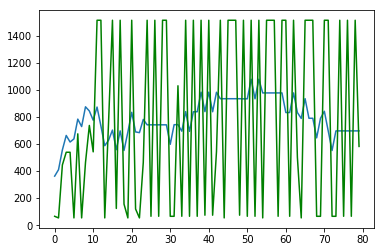

In [0]:
plt.plot(df3.pkt_length.values[20:100])
plt.plot(df.pkt_length.values[20:100], 'g')

In [0]:
df3

,pkt_length,tcp_window_size_value,stalling_event,measure,capture
9,288.1,26718.7,0,0,5
10,286.9,25925.1,0,0,5
11,381.9,32364.4,0,0,5
12,381.9,32389.6,0,0,5
13,414.9,25914.8,0,0,5
14,464.0,25951.4,0,0,5
15,610.0,32381.8,0,0,5
16,610.0,32381.8,0,0,5
17,669.1,38786.6,0,0,5
18,620.6,33141.2,0,0,5


In [0]:
X_train, y_train, X_test, y_test = split_dataset(df3)

In [0]:
model, history = build_model(X_train, y_train, X_test, y_test)

Train on 35712 samples, validate on 8704 samples
Epoch 1/10
35712/35712 [==============================] - 53s 1ms/step - loss: 0.0317 - val_loss: 0.0066
Epoch 2/10
35712/35712 [==============================] - 51s 1ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 3/10
35712/35712 [==============================] - 52s 1ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/10
35712/35712 [==============================] - 52s 1ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 5/10
35712/35712 [==============================] - 51s 1ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 6/10
35712/35712 [==============================] - 52s 1ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 7/10
35712/35712 [==============================] - 51s 1ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 8/10
35712/35712 [==============================] - 51s 1ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 9/10
35712/35712 [==============================] - 51s 1ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 

dict_keys(['val_loss', 'loss'])


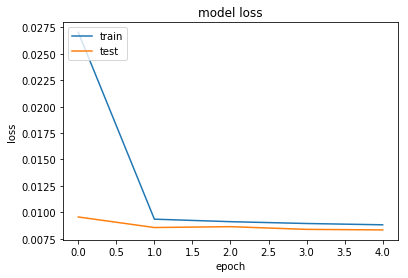

In [0]:
plot_history(history)

In [0]:
yhat = model.predict(X_test, verbose=1)

8704/8704 [==============================] - 4s 492us/step


In [0]:
print(y_test.shape)
print(yhat.shape)

(8704, 100, 2)
(8704, 100, 2)


In [0]:
y_test[1021]

array([[0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.71070013, 0.99065158],
       [0.71070013, 0.99065158],
       [0.61426684, 0.99242792],
       [0.

In [0]:
yhat[0]

array([[0.60787714, 0.6357446 ],
       [0.6000288 , 0.6464028 ],
       [0.6050814 , 0.6481992 ],
       [0.6056485 , 0.64608705],
       [0.60543877, 0.6425863 ],
       [0.60517234, 0.63946605],
       [0.60494936, 0.6370445 ],
       [0.60477936, 0.63523924],
       [0.6046535 , 0.63390714],
       [0.60456055, 0.6329224 ],
       [0.60449153, 0.6321887 ],
       [0.60444   , 0.6316359 ],
       [0.60440123, 0.63121444],
       [0.60437125, 0.63088936],
       [0.6043482 , 0.6306353 ],
       [0.60432976, 0.6304343 ],
       [0.6043151 , 0.6302734 ],
       [0.6043034 , 0.63014334],
       [0.6042938 , 0.6300373 ],
       [0.6042858 , 0.62994975],
       [0.60427934, 0.6298768 ],
       [0.6042737 , 0.6298159 ],
       [0.6042692 , 0.6297644 ],
       [0.6042651 , 0.62972057],
       [0.60426164, 0.6296832 ],
       [0.6042588 , 0.62965083],
       [0.6042564 , 0.6296231 ],
       [0.6042542 , 0.6295988 ],
       [0.6042522 , 0.62957776],
       [0.60425043, 0.62955916],
       [0.

In [0]:
y_test[1021:1024]

array([[[0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.61426684, 0.99242792],
        [0.71070013, 0.99065158],
        [0.71070013, 0.99065158],
        [0.614

In [0]:
yhat.shape

(8704, 100, 2)

In [0]:
a=y_test.reshape(y_test.shape[0]*y_test.shape[2], y_test.shape[1])
b=yhat.reshape(yhat.shape[0]*yhat.shape[2], yhat.shape[1])
c=X_test.reshape(X_test.shape[0]*X_test.shape[2], X_test.shape[1])


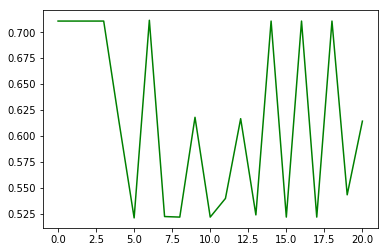

In [0]:
plt.plot(c[1000:1021, 0], 'g')


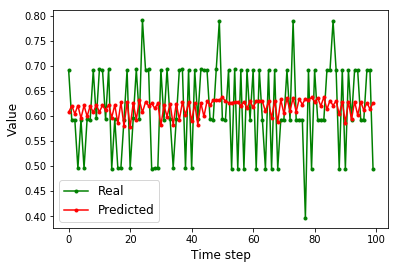

In [0]:
n_vent=1024
n_pred=100
n=4

plt.plot(a[(n*n_vent)-n_pred:(n*n_vent), 1], 'g', marker='.', label= "Real")
plt.plot(b[(n*n_vent)-n_pred:(n*n_vent), 1], 'r', marker='.', label = "Predicted")
plt.plot(figsize=(20,10))
plt.ylabel('Value', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12)
plt.savefig("./gdrive/My Drive/Colab Notebooks/Pruebas/Pred_0.008Error.svg")
plt.show()


In [0]:
stop

NameError: ignored

In [0]:
print(a[(n*n_vent)-n_pred:(n*n_vent), 1])

[0.6911091  0.59294071 0.59294071 0.49537415 0.59294071 0.49537415
 0.59414438 0.59294071 0.6911091  0.59534805 0.69291461 0.69231277
 0.59354254 0.69351644 0.49477232 0.59354254 0.49537415 0.49717966
 0.59294071 0.69171093 0.49597599 0.59534805 0.69291461 0.59474622
 0.791083   0.69231277 0.69291461 0.49477232 0.49657782 0.49537415
 0.69231277 0.59294071 0.69291461 0.59354254 0.49717966 0.59354254
 0.69231277 0.69291461 0.49537415 0.69171093 0.49537415 0.6911091
 0.59354254 0.69291461 0.69171093 0.6911091  0.59354254 0.59294071
 0.69291461 0.78927749 0.59354254 0.59294071 0.69171093 0.49477232
 0.69291461 0.49476617 0.6911091  0.49477232 0.6911091  0.59294071
 0.6911091  0.49477232 0.6911091  0.59294071 0.49477232 0.6911091
 0.49476617 0.6911091  0.49476617 0.59294071 0.59294071 0.6911091
 0.59294071 0.78927749 0.59294071 0.59294071 0.59294071 0.39660392
 0.6911091  0.49477232 0.6911091  0.59294071 0.59294071 0.59294071
 0.6911091  0.6911091  0.78927749 0.6911091  0.49477232 0.6911091

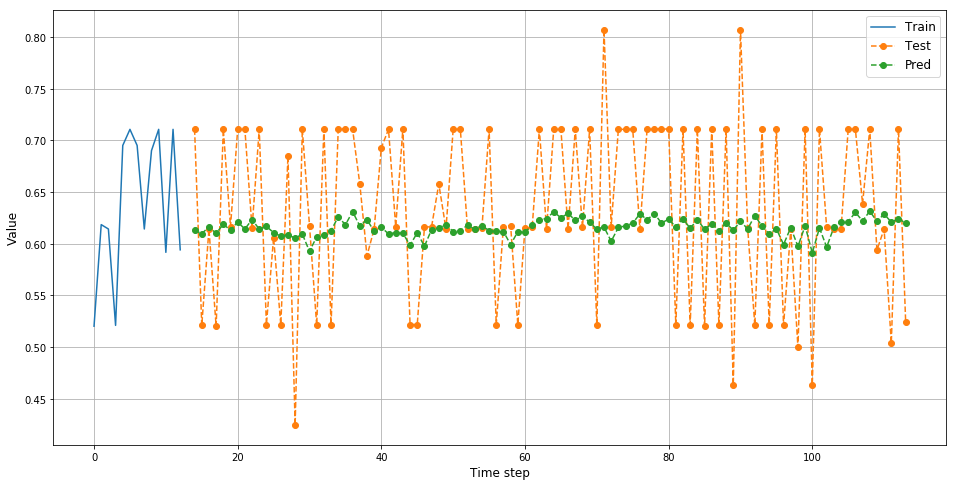

In [0]:
n_vent=1024
n_pred=100
n=1
plt.figure(figsize=(16,8))
plt.plot(np.arange(13), c[910:923, 0], label = 'Train')
#plt.plot(a[(n*n_vent)-n_pred:(n*n_vent), 0], label='Test') #si predigo 24 por ej, seria y_test[1000: 1024]
#plt.plot(b[(n*n_vent)-n_pred:(n*n_vent), 0], label='Pred', color='r')
plt.plot(np.arange(14,114), a[924:(n*n_vent), 0], label='Test', marker= '.',markersize=12, linestyle='dashed')
plt.plot(np.arange(14,114), b[924:(n*n_vent), 0], label='Pred', marker= '.',markersize=12, linestyle='dashed')
plt.savefig("./gdrive/My Drive/Colab Notebooks/Pruebas/Pred_0.008Error.svg")
plt.ylabel('Value', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12, loc= 'best')
plt.grid(1)
plt.show()

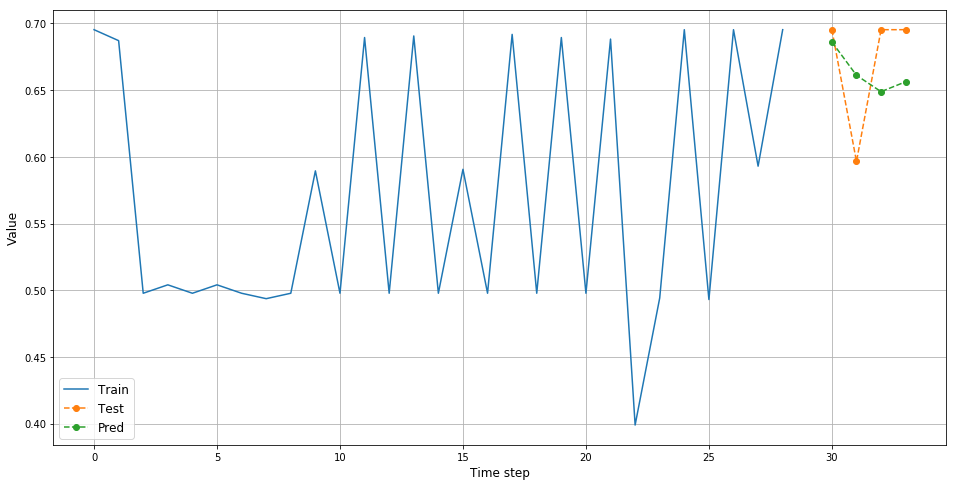

In [0]:
n_vent=1024
n_pred=4
n=1
plt.figure(figsize=(16,8))
plt.plot(np.arange(29), c[970:999, 1], label = 'Train')
#plt.plot(a[(n*n_vent)-n_pred:(n*n_vent), 0], label='Test') #si predigo 24 por ej, seria y_test[1000: 1024]
#plt.plot(b[(n*n_vent)-n_pred:(n*n_vent), 0], label='Pred', color='r')
plt.plot(np.arange(30,34), a[1020:(n*n_vent), 1], label='Test', marker= '.',markersize=12, linestyle='dashed')
plt.plot(np.arange(30,34), b[1020:(n*n_vent), 1], label='Pred', marker= '.',markersize=12, linestyle='dashed')
plt.savefig("./gdrive/My Drive/Colab Notebooks/Pruebas/Pred4_0.003Error.svg")
plt.ylabel('Value', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12, loc= 'best')
plt.grid(1)
plt.show()

In [0]:
y_test[2045:2048,2]

In [0]:
a[2045:2048, 2]

In [0]:
yhat[2045:2048, 2]

In [0]:
plt.plot(a[2045:2048,1], 'g', marker='.')
plt.plot(b[2045:2048,1], 'r', marker='.')

In [0]:
plt.plot(a[0:20,0], 'g', marker='.', label="actual")
plt.plot(b[0:20,0], 'r', marker='.', label="pred")
plt.ylabel('Feature 1', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12)
plt.show()

In [0]:

plt.plot(a[0:20,1], 'g', marker='.', label="actual")
plt.plot(b[0:20,1], 'r', marker='.', label="pred")
plt.ylabel('Feature 2', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12)
plt.show()

In [0]:
plt.plot(a[20:40,2], 'g', marker='.', label="actual")
plt.plot(b[20:40,2], 'r', marker='.', label="pred")
plt.ylabel('Feature 3', size=12)
plt.xlabel('Time step', size=12)
plt.legend(fontsize=12)
plt.show()

In [0]:
c = np.reshape(X_test[2], (1, -1, 3))
model.predict(c)

In [0]:
y_test[2]

In [0]:
yhat[2]

In [0]:
y_test[2]

In [0]:
stop

In [0]:
from sklearn.externals import joblib
joblib.dump(model, './gdrive/My Drive/Colab Notebooks/Pruebas/pred_model_BEST.pkl')
joblib.dump(df2, './gdrive/My Drive/Colab Notebooks/Pruebas/df2.pkl')

In [0]:
from sklearn.externals import joblib


In [0]:
m_load = joblib.load('./gdrive/My Drive/Colab Notebooks/Pruebas/pred_model7.pkl')
yhat = m_load.predict(X_test, verbose=1)

In [0]:
values = [4, 8, 16, 24, 48, 64, 100]

results = [0.0030630729015683755, 0.004141439735095072, 0.006426084161777159, 0.006438360155751819, 0.007488114070249996, 0.007698553662254091, 0.0080]
plt.plot(values, results, marker='o')
plt.xlabel('Size of the forecast')
plt.ylabel('Error')

plt.show()

Text(0, 0.5, 'Test Accuracy')

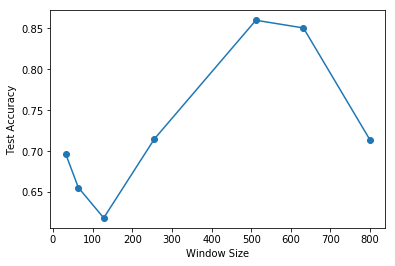

In [0]:
values = [32, 64, 128, 256, 512, 632, 800]
Acc = [0.6967477292704366, 0.6555380989787902, 0.6184703155642717, 0.71504458357048, 0.86, 0.8505747126436781, 0.7137] 

plt.plot(values, Acc, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Test Accuracy')